# Multi - Class Classification

## creating an multi class classification data

lets use `make_blob` data from sklearn

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [3]:

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [4]:

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

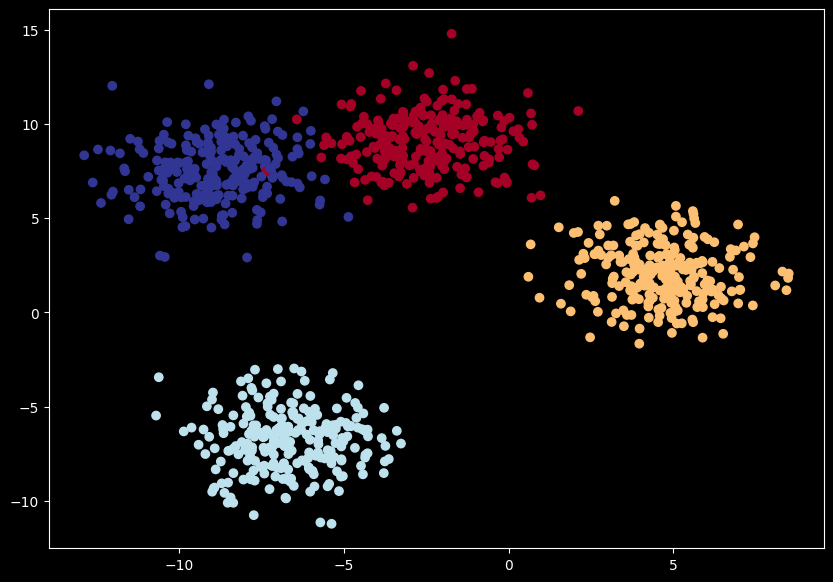

In [5]:

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

lets turn our data into tensor

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## creating loss funtion and Optimizer

In [8]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model(X_blob_train.to(device))[:5]

tensor([[-1.4034,  2.6365, -0.0839, -0.5780],
        [-1.8847,  3.1580,  1.6927, -0.7655],
        [ 4.6094, -5.3456, -1.7316,  1.2006],
        [ 2.8176, -2.9876, -0.9504,  0.6626],
        [-1.0805,  2.1052,  1.2657, -0.5220]], grad_fn=<SliceBackward0>)

In [10]:
# How many elements in a single prediction sample?
model(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [11]:
# Make prediction logits with model
y_logits = model(X_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.6848,  2.9966,  0.1826, -0.6665],
        [-0.1632,  0.8527,  1.5006, -0.2639],
        [ 3.8675, -4.3529, -1.6354,  0.9841],
        [-0.5385,  1.4964, -0.4325, -0.3191],
        [-2.5091,  4.0014,  1.6616, -0.9447]], grad_fn=<SliceBackward0>)
tensor([[8.4636e-03, 9.1333e-01, 5.4773e-02, 2.3431e-02],
        [1.0055e-01, 2.7770e-01, 5.3084e-01, 9.0913e-02],
        [9.4314e-01, 2.5381e-04, 3.8432e-03, 5.2764e-02],
        [9.0839e-02, 6.9504e-01, 1.0100e-01, 1.1312e-01],
        [1.3464e-03, 9.0502e-01, 8.7196e-02, 6.4357e-03]],
       grad_fn=<SliceBackward0>)


In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fun(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fun(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 3.20515, Acc: 26.00% | Test Loss: 2.59125, Test Acc: 20.50%
Epoch: 10 | Loss: 0.46537, Acc: 88.00% | Test Loss: 0.40288, Test Acc: 92.50%
Epoch: 20 | Loss: 0.19220, Acc: 98.88% | Test Loss: 0.17733, Test Acc: 99.00%
Epoch: 30 | Loss: 0.09720, Acc: 98.88% | Test Loss: 0.08733, Test Acc: 100.00%
Epoch: 40 | Loss: 0.06400, Acc: 99.38% | Test Loss: 0.05828, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04860, Acc: 99.12% | Test Loss: 0.04017, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04116, Acc: 99.12% | Test Loss: 0.03352, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03706, Acc: 99.12% | Test Loss: 0.02887, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03431, Acc: 99.38% | Test Loss: 0.02572, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03231, Acc: 99.25% | Test Loss: 0.02378, Test Acc: 99.50%


In [14]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.7688,  10.2102, -11.7954,  -8.7995],
        [  3.7538, -10.8981,   1.5251,   9.2796],
        [ -8.6262, -11.6596,  18.2672,   9.4673],
        [  1.6527,   7.6907,  -6.2598,  -6.7543],
        [  8.5256,   3.3956, -12.8760,  -2.8092],
        [  4.1799, -13.6674,   2.5360,  11.6725],
        [ -8.8191,  -8.6739,  16.8263,   6.8974],
        [  7.0458,  -0.3734,  -8.7868,   0.3701],
        [ -9.0520, -16.6056,  21.6361,  13.6965],
        [  7.4411,   1.0090, -10.0924,  -0.8016]])

In [15]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [16]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
"""
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


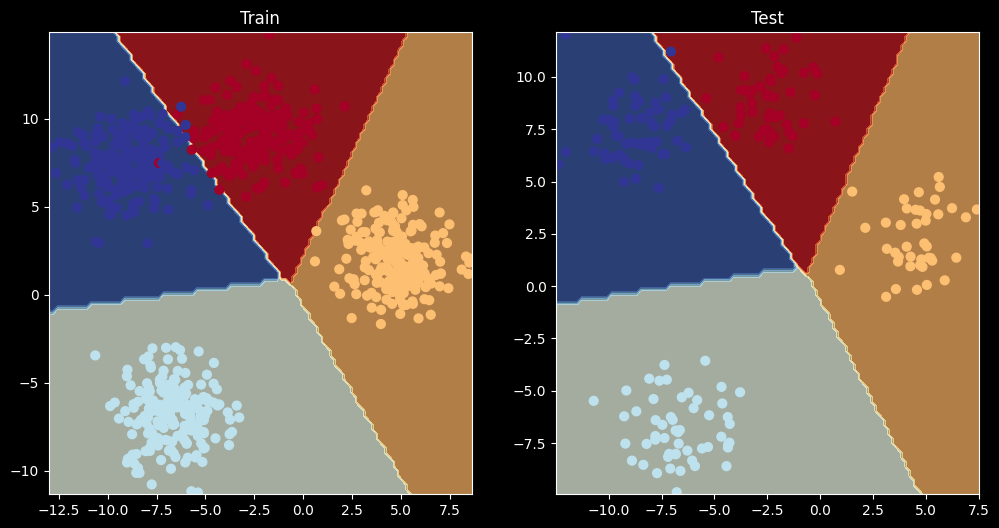

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)